对抗自编码器

暂时没用

Epoch [1/5], CAE Loss: 0.0053
Epoch [2/5], CAE Loss: 0.0034
Epoch [3/5], CAE Loss: 0.0020
Epoch [4/5], CAE Loss: 0.0019
Epoch [5/5], CAE Loss: 0.0016
Epoch [1/10], D Loss: 0.2627, G Loss: 3.0225
Epoch [2/10], D Loss: 0.2458, G Loss: 1.9265
Epoch [3/10], D Loss: 0.5205, G Loss: 1.3280
Epoch [4/10], D Loss: 0.8227, G Loss: 0.8042
Epoch [5/10], D Loss: 0.6381, G Loss: 0.9379
Epoch [6/10], D Loss: 0.3312, G Loss: 1.7991
Epoch [7/10], D Loss: 0.2379, G Loss: 2.0009
Epoch [8/10], D Loss: 0.1182, G Loss: 2.5692
Epoch [9/10], D Loss: 0.2519, G Loss: 3.8113
Epoch [10/10], D Loss: 0.4039, G Loss: 3.3000


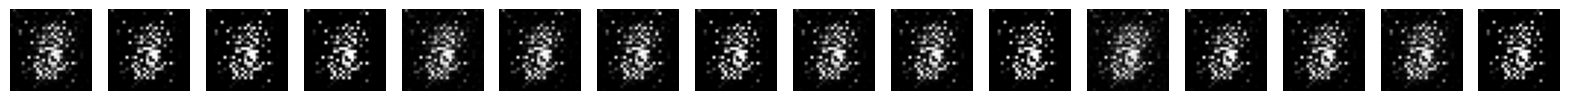

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 加载 MNIST 数据集
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义卷积自编码器 (CAE)
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [32, 7, 7]
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [1, 28, 28]
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 定义生成对抗网络 (GAN)
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cae = CAE().to(device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 损失函数和优化器
adversarial_loss = nn.BCELoss()
cae_optimizer = optim.Adam(cae.parameters(), lr=0.001)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# 训练卷积自编码器 (CAE)
cae_epochs = 5
for epoch in range(cae_epochs):
    cae.train()
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        # 前向传播
        outputs = cae(imgs)
        loss = nn.MSELoss()(outputs, imgs)
        # 反向传播
        cae_optimizer.zero_grad()
        loss.backward()
        cae_optimizer.step()
    print(f"Epoch [{epoch + 1}/{cae_epochs}], CAE Loss: {loss.item():.4f}")

# 训练生成对抗网络 (GAN)
gan_epochs = 10
latent_dim = 100
for epoch in range(gan_epochs):
    for imgs, _ in train_loader:
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)
        real_imgs = imgs.to(device)

        # 训练生成器
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        generated_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(generated_imgs), valid)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # 训练判别器
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

    print(f"Epoch [{epoch + 1}/{gan_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# 生成一些新图像
z = torch.randn(16, latent_dim).to(device)
generated_imgs = generator(z).cpu().detach()

# 可视化生成的图像
fig, axes = plt.subplots(1, 16, figsize=(20, 2))
for i in range(16):
    axes[i].imshow(generated_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()